In [1]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary
np.set_printoptions(suppress=True)
np.random.seed(2)
torch.cuda.manual_seed_all(2)
plt.style.use("fivethirtyeight")
C = 4
ndim = 3

#p_vals = np.arange(1, 40, 2)

# data distribution
gaussians = [
    mvn(mean=[-3, 0, 0], cov=np.eye(3)),
    mvn(mean=[1, 0, 0], cov=np.eye(3)),
    mvn(mean=[0, 0, 1], cov=np.eye(3)),
    mvn(mean=[0, 0, -3], cov=np.eye(3))
]

def create_data(N):
    X = np.concatenate([g.rvs(size=N //4) for g in gaussians])
    y = np.concatenate((np.zeros(N//4), np.ones(N//4), 2 * np.ones(N//4), 3 * np.ones(N//4)))
    return X, y

#generating datasets
X100, Y100 = create_data(100)
X200, Y200 = create_data(200)
X500, Y500 = create_data(500)
X1000, Y1000 = create_data(1000)
X2000, Y2000 = create_data(2000)
X5000, Y5000 = create_data(5000)
X100K, Y100K = create_data(100000)

In [3]:
#theoretically optimum
class_cond_likelihoods = np.array([i.pdf(X100K) * 0.25 for i in gaussians]) #4 classes present so * 0.25
X10K_pred = pd.DataFrame(
    np.hstack(
        (class_cond_likelihoods.T, np.argmax(class_cond_likelihoods, axis=0).reshape(-1, 1), #reshaping to have 2 dim
         Y100K.reshape(-1, 1), #reshaping to have 2 dim
        )),columns=["0", "1", "2", "3", "Predicted", "Class"],).assign(trueclass=lambda df: df.Predicted == df.Class)

err_rate = 1 - X10K_pred.trueclass.mean()
print(f'Theoretical minimum error rate: {err_rate:.3%}')

Theoretical minimum error rate: 17.987%


In [4]:
pvals = np.arange(1, 40,2)
input_dim = ndim
output_dim = C

class Model(nn.Sequential): #defining a class that has all common functions

    def __init__(self, p=10):
        super().__init__(
            nn.Linear(input_dim, p), 
            nn.ReLU(),
            nn.Linear(p, output_dim), 
            nn.Softmax(dim=1)
        )
        super().to("cuda")
        self.p = p

    def model_train(self, data, labels, criterion, optimizer, num_epochs, reset_params=True):
      #reinstate model
      if reset_params:
        self.reset_params()
      torch.cuda.manual_seed_all(0)
      # Apparently good practice to set this "flag" too before training
     # Does things like make sure Dropout layers are active, gradients are updated, etc.
     # Probably not a big deal for our toy network, but still worth developing good practice
      self.train()
      #optimizer = optimizer(self.parameters())

      for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = self(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()

      return self

    def predict(self, data):
      # Similar idea to model.train(), set a flag to let network know your in "inference" mode
      self.eval()
     # Disabling gradient calculation is useful for inference, only forward pass!!
      with torch.no_grad():
        # Evaluate nn on test data and compare to true labels
        predicted_labels = self(data)
        # Back to numpy
        predicted_labels = predicted_labels.detach().cpu().numpy()

      return np.argmax(predicted_labels, 1)

    #to reinstate the model to an unlearned state by resetting the parameters of the neural network. 
    @torch.no_grad()
    def reset_params(self):
      for layer in self.children():
        if hasattr(layer, "reset_params"):
          layer.reset_params()

In [5]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, shuffle=True)

def cross_val(X, y, p):
    err_per_k = []
    for train_idx, kf_idx in k_fold.split(X):
        
        model = Model(p)
        X_train = X[train_idx]
        y_train = y[train_idx]

        # Stochastic GD with learning rate and momentum hyperparameters
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        # The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
        # the output when validating, on top of calculating the negative log-likelihood using 
        # nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
        criterion = nn.CrossEntropyLoss()
        num_epochs = 100

        # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
        X_tensor = torch.FloatTensor(X_train).to(torch.device("cuda"))
        y_tensor = torch.LongTensor(y_train).to(torch.device("cuda"))

        model.model_train(X_tensor, y_tensor,criterion, optimizer, num_epochs=num_epochs)

        X_k = X[kf_idx]
        y_k = y[kf_idx]

        y_pred = model.predict(torch.FloatTensor(X_k).to(torch.device("cuda")))
        tot = y_k.shape[0]
        err = y_pred[y_pred != y_k].shape[0]
        err_rate = err / tot
        err_per_k.append(err_rate)

    mean_err = np.mean(err_per_k )
    return mean_err


In [6]:
def train_crossval(X, y, p_vals):
    err_list = np.array([cross_val(X, y, p) for p in p_vals])

    p_opt = p_vals[np.argmin(err_list)]
    min_error = np.min(err_list)
    return p_opt, min_error, err_list
p_100, min_err100, err100 = train_crossval(X100, Y100, pvals)
p_200, min_err200, err200 = train_crossval( X200, Y200, pvals)
p_500, min_err500, err500 = train_crossval(X500, Y500, pvals)
p_1k, min_err1k, err1000 = train_crossval(X1000, Y1000, pvals )
p_2k, min_err2k, err2000 = train_crossval(X2000, Y2000, pvals )
p_5k, min_err5k, err5000 = train_crossval(X5000, Y5000, pvals)

In [7]:
print('Optimal P* for respective training samples:')
print(f'For 100 samples: {p_100}')
print(f'For 200 samples: {p_200}')
print(f'For 500 samples: {p_500}')
print(f'For 1000 samples: {p_1k}')
print(f'For 2000 samples: {p_2k}')
print(f'For 5000 samples: {p_5k}')

print('\n')
print('Error rate for respective training samples:')
print(f'For 100 samples :{ min_err100:.1%}')
print(f'For 200 samples: {min_err200:.1%}')
print(f'For 500 samples: {min_err500:.1%}')
print(f'For 1000 samples: {min_err1k:.1%}')
print(f'For 2000 samples: {min_err2k:.1%}')
print(f'For 5000 samples: {min_err5k:.1%}')

Optimal P* for respective training samples:
For 100 samples: 35
For 200 samples: 39
For 500 samples: 37
For 1000 samples: 31
For 2000 samples: 37
For 5000 samples: 37


Error rate for respective training samples:
For 100 samples :16.0%
For 200 samples: 26.0%
For 500 samples: 22.8%
For 1000 samples: 25.0%
For 2000 samples: 22.2%
For 5000 samples: 23.9%


In [8]:
# Stochastic GD with learning rate and momentum hyperparameters

# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
# the output when validating, on top of calculating the negative log-likelihood using 
# nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
criterion = nn.CrossEntropyLoss()
num_epochs = 100

m100 = Model(p_100)
opt100 = torch.optim.SGD(m100.parameters(), lr=0.01, momentum=0.9)
m100.model_train(torch.FloatTensor(X100).to(torch.device("cuda")),torch.LongTensor(Y100).to(torch.device("cuda")),criterion, opt100, num_epochs)
pred100 = m100.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER100 = pred100[pred100 != Y100K].shape[0] / Y100K.shape[0]


m200 = Model(p_200)
opt200 = torch.optim.SGD(m200.parameters(), lr=0.01, momentum=0.9)
m200.model_train(torch.FloatTensor(X200).to(torch.device("cuda")),torch.LongTensor(Y200).to(torch.device("cuda")),criterion, opt200, num_epochs)
pred200 = m200.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER200 = pred200[pred200 != Y100K].shape[0] / Y100K.shape[0]

m500 = Model(p_500)
opt500 = torch.optim.SGD(m500.parameters(), lr=0.01, momentum=0.9)
m500.model_train(torch.FloatTensor(X500).to(torch.device("cuda")),torch.LongTensor(Y500).to(torch.device("cuda")),criterion, opt500, num_epochs)
pred500 = m500.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER500 = pred500[pred500 != Y100K].shape[0] / Y100K.shape[0]

m1000 = Model(p_1k)
opt1k = torch.optim.SGD(m1000.parameters(), lr=0.01, momentum=0.9)
m1000.model_train(torch.FloatTensor(X1000).to(torch.device("cuda")),torch.LongTensor(Y1000).to(torch.device("cuda")), criterion, opt1k, num_epochs)
pred1000 = m1000.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER1000 = pred1000[pred1000 != Y100K].shape[0] / Y100K.shape[0]

m2000 = Model(p_2k)
opt2k = torch.optim.SGD(m2000.parameters(), lr=0.01, momentum=0.9)
m2000.model_train(torch.FloatTensor(X2000).to(torch.device("cuda")),torch.LongTensor(Y2000).to(torch.device("cuda")), criterion, opt2k, num_epochs)
pred2000 = m2000.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER2000 = pred2000[pred2000 != Y100K].shape[0] / Y100K.shape[0]

m5000 = Model(p_5k)
opt5k = torch.optim.SGD(m5000.parameters(), lr=0.01, momentum=0.9)
m5000.model_train(torch.FloatTensor(X5000).to(torch.device("cuda")),torch.LongTensor(Y5000).to(torch.device("cuda")), criterion, opt5k, num_epochs)
pred5000 = m5000.predict(torch.FloatTensor(X100K).to(torch.device("cuda")))
ER5000 = pred5000[pred5000 != Y100K].shape[0] / Y100K.shape[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


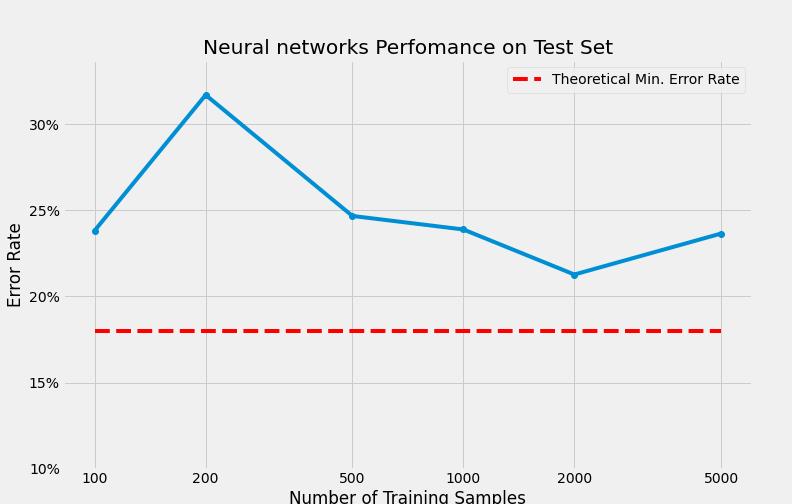

In [9]:
from google.colab import output
output.enable_custom_widget_manager()
x = [100, 200, 500, 1000, 2000, 5000]
y = [ER100,ER200,ER500,ER1000,ER2000,ER5000]
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_xscale('log')
ax.plot(x, y, 'o-')
ax.set_ylim(0.1, np.max(y) + 0.02)
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.hlines(err_rate, x[0], x[-1], colors='red', linestyles='dashed', label='Theoretical Min. Error Rate')
ax.set_title('Neural networks Perfomance on Test Set')
ax.set_xlabel('Number of Training Samples')
ax.set_ylabel('Error Rate')
ax.legend()

In [10]:

print(f'Error rate on test set using 100 training samples: {ER100:.3%}')
print(f'Error rate on test set using 200 training samples: {ER200:.3%}')
print(f'Error rate on test set using 500 training samples: {ER500:.3%}')
print(f'Error rate on test set using 1k training samples: {ER1000:.3%}')
print(f'Error rate on test set using 2k training samples: {ER2000:.3%}')
print(f'Error rate on test set using 5k training samples: {ER5000:.3%}')

Error rate on test set using 100 training samples: 23.823%
Error rate on test set using 200 training samples: 31.691%
Error rate on test set using 500 training samples: 24.669%
Error rate on test set using 1k training samples: 23.884%
Error rate on test set using 2k training samples: 21.270%
Error rate on test set using 5k training samples: 23.647%


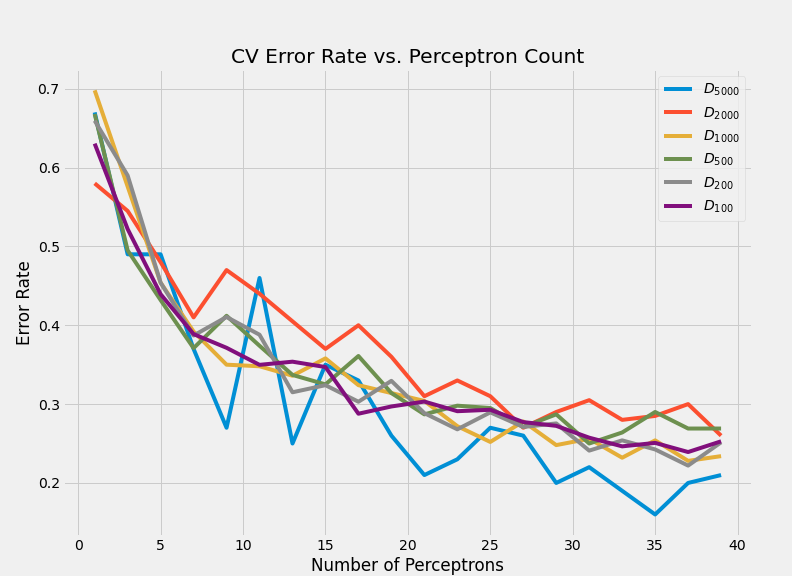

In [11]:
def cv_err_vs_pcount(err, labels, p_vals):
    _, ax = plt.subplots(figsize=(11, 8))
    
    for er, lab in zip(err, labels):
        ax.plot(p_vals, er, label=lab)
    ax.set_title(f'CV Error Rate vs. Perceptron Count')
    ax.set_xlabel('Number of Perceptrons')
    ax.set_ylabel('Error Rate')
    ax.legend()

errors=[err100,err200,err500,err1000, err2000,err5000]
labels=[r"$D_{5000}$", r"$D_{2000}$", r"$D_{1000}$", r"$D_{500}$", r"$D_{200}$", r"$D_{100}$"]
cv_err_vs_pcount(errors,labels, p_vals=pvals,)